In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_0'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_0'
parquet_verzeichnis_hybrid = '../01_Datensaetze/improved_hybrid_b17'

## Datensätze laden

In [ ]:
df_ids18 = pd.read_parquet(parquet_verzeichnis_ids18)
df_ids17 = pd.read_parquet(parquet_verzeichnis_ids17)
df_hybrid = pd.read_parquet(parquet_verzeichnis_hybrid)

## Klassenübersichten anzeigen

In [ ]:
# Entferne nicht verwendete Kategorien aus der 'Label'-Spalte in ids18
df_ids18['Label'] = df_ids18['Label'].cat.remove_unused_categories()

In [32]:
ids18_class_counts = df_ids18['Label'].value_counts()
print(ids18_class_counts)

Label
BENIGN                          5935340
DoS Hulk                        1803160
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64


In [34]:
ids17_class_counts = df_ids17['Label'].value_counts()
print(ids17_class_counts)

Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64


In [36]:
hybrid_class_counts = df_hybrid['Label'].value_counts()
print(hybrid_class_counts)

Label
DoS Hulk                        1961628
BENIGN                          1582561
DDoS-LOIC-HTTP                   384472
Infiltration - NMAP Portscan     161141
Botnet Ares                      143657
SSH-BruteForce                    97158
DoS GoldenEye                     30127
DoS Slowloris                     12349
Name: count, dtype: int64


## Feature Selection

### Random Forest Classifier

In [ ]:
# Lade den Datensatz
data = df_ids18

# Features und Zielvariable trennen
X = data.drop('Label', axis=1)
y = data['Label']

# Random Forest trainieren
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature Importances extrahieren
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

                  feature  importance
68     FWD Init Win Bytes    0.122923
71       Fwd Seg Size Min    0.092338
11  Bwd Packet Length Max    0.047949
14  Bwd Packet Length Std    0.047245
42      Packet Length Max    0.046621
0                Dst Port    0.040398
69     Bwd Init Win Bytes    0.036880
50         ACK Flag Count    0.036686
57   Bwd Segment Size Avg    0.034328
4       Total Bwd packets    0.031593


In [ ]:
# Wichtigste Features ausgeben
print(feature_importance_df.head(30))

                       feature  importance
68          FWD Init Win Bytes    0.122923
71            Fwd Seg Size Min    0.092338
11       Bwd Packet Length Max    0.047949
14       Bwd Packet Length Std    0.047245
42           Packet Length Max    0.046621
0                     Dst Port    0.040398
69          Bwd Init Win Bytes    0.036880
50              ACK Flag Count    0.036686
57        Bwd Segment Size Avg    0.034328
4            Total Bwd packets    0.031593
46              FIN Flag Count    0.028086
32               Bwd PSH Flags    0.026837
20                Flow IAT Min    0.024633
7        Fwd Packet Length Max    0.023776
25                 Fwd IAT Min    0.023467
10       Fwd Packet Length Std    0.018354
13      Bwd Packet Length Mean    0.017683
6   Total Length of Bwd Packet    0.017674
26               Bwd IAT Total    0.014939
67           Subflow Bwd Bytes    0.014075
38           Bwd Header Length    0.013955
45      Packet Length Variance    0.013949
56        F

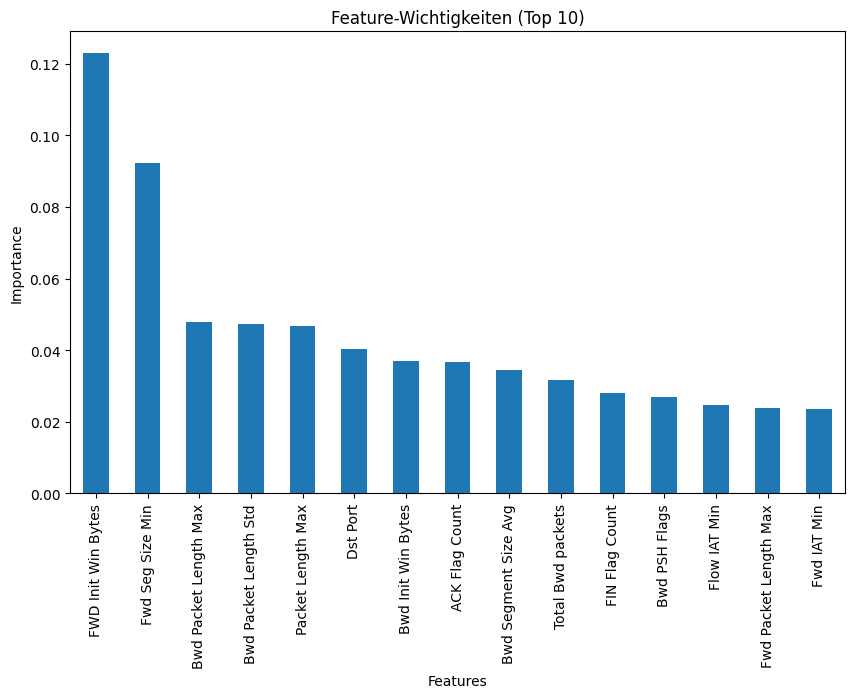

In [55]:
# Balkendiagramm der Feature-Wichtigkeiten
feature_importance_df.head(15).plot(
    x='feature', y='importance', kind='bar', legend=False, figsize=(10, 6)
)
plt.title('Feature-Wichtigkeiten (Top 10)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

### Korrelationsmatrix

In [ ]:
# Korrelationsmatrix berechnen
correlation_matrix = X.corr()

# Features mit hoher Korrelation finden
threshold = 0.9
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print('Features mit hoher Korrelation:', high_corr_features)

Features mit hoher Korrelation: {'Subflow Bwd Bytes', 'Bwd Segment Size Avg', 'ACK Flag Count', 'Bwd Packet/Bulk Avg', 'Total Length of Bwd Packet', 'Idle Max', 'Fwd Bytes/Bulk Avg', 'Fwd IAT Max', 'PSH Flag Count', 'Fwd Packets/s', 'Fwd Segment Size Avg', 'Flow IAT Max', 'Idle Min', 'Fwd Packet/Bulk Avg', 'Packet Length Min', 'Subflow Fwd Bytes', 'Packet Length Std', 'Fwd Packet Length Std', 'Packet Length Variance', 'Active Max', 'Bwd Packet Length Std', 'Packet Length Max', 'Bwd IAT Total', 'URG Flag Count', 'ECE Flag Count', 'Idle Mean', 'Average Packet Size', 'Bwd Packets/s', 'Bwd IAT Max', 'Active Min', 'Bwd IAT Std'}


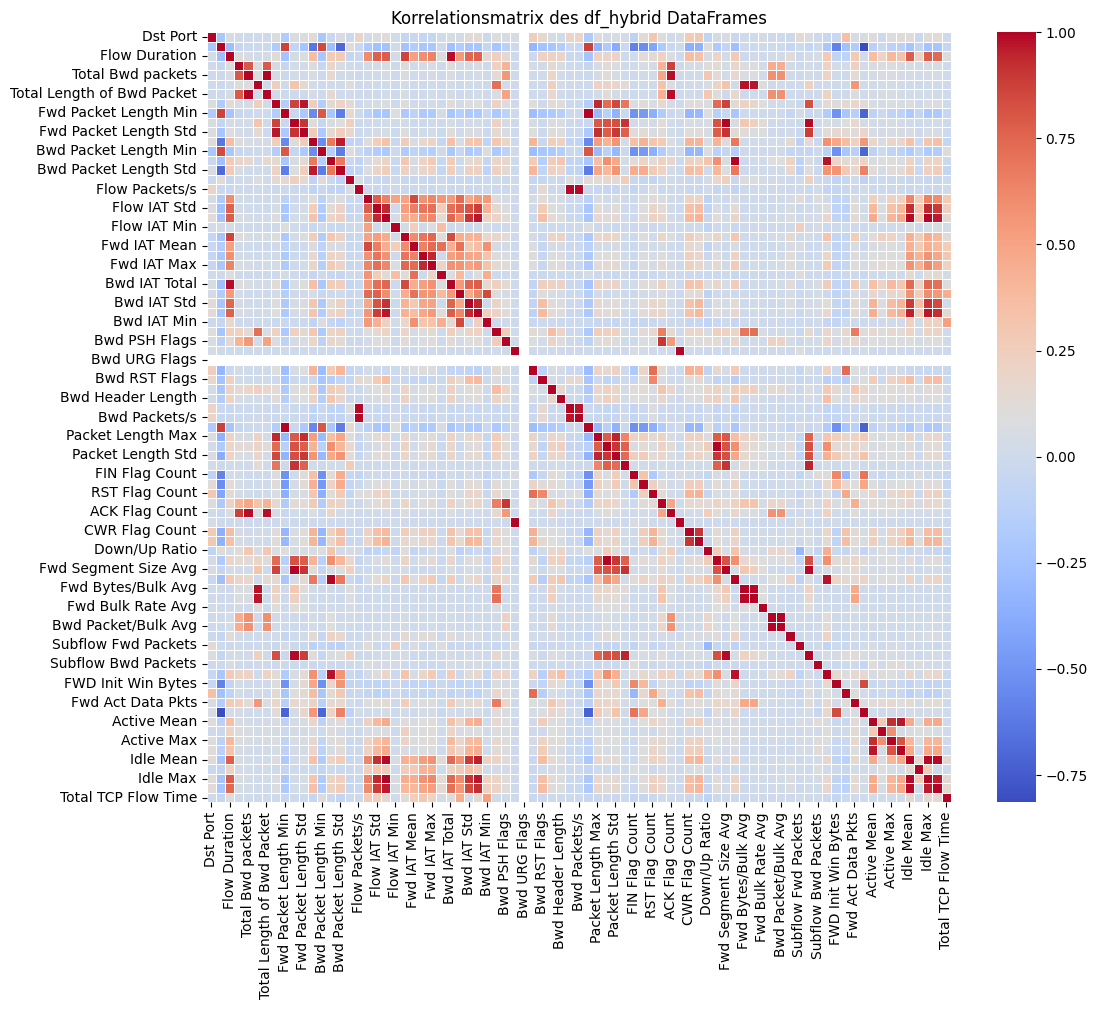

In [58]:
# Größe der Grafik 
plt.figure(figsize=(12, 10))

# Heatmap erstellen
sns.heatmap(correlation_matrix, 
            annot=False,        # Korrelationskoeffizienten anzeigen
            fmt=".2f",         # Format der Koeffizienten
            cmap="coolwarm",   # Farbschema der Heatmap
            linewidths=0.5)    # Linien zwischen den Zellen

# Titel hinzufügen (optional)
plt.title("Korrelationsmatrix des df_hybrid DataFrames")

# Grafik anzeigen
plt.show()

In [43]:
# Finde stark korrelierte Paare
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(pair)

# Liste der Paare anzeigen
for pair in high_corr_pairs:
    print(f"Stark korreliertes Paar: {pair}")


Stark korreliertes Paar: ('Total Length of Bwd Packet', 'Total Bwd packets')
Stark korreliertes Paar: ('Fwd Packet Length Std', 'Fwd Packet Length Max')
Stark korreliertes Paar: ('Fwd Packet Length Std', 'Fwd Packet Length Mean')
Stark korreliertes Paar: ('Bwd Packet Length Std', 'Bwd Packet Length Max')
Stark korreliertes Paar: ('Flow IAT Max', 'Flow IAT Std')
Stark korreliertes Paar: ('Fwd IAT Max', 'Fwd IAT Std')
Stark korreliertes Paar: ('Bwd IAT Total', 'Flow Duration')
Stark korreliertes Paar: ('Bwd IAT Std', 'Flow IAT Max')
Stark korreliertes Paar: ('Bwd IAT Max', 'Flow IAT Max')
Stark korreliertes Paar: ('Bwd IAT Max', 'Bwd IAT Std')
Stark korreliertes Paar: ('Fwd Packets/s', 'Flow Packets/s')
Stark korreliertes Paar: ('Bwd Packets/s', 'Flow Packets/s')
Stark korreliertes Paar: ('Bwd Packets/s', 'Fwd Packets/s')
Stark korreliertes Paar: ('Packet Length Min', 'Fwd Packet Length Min')
Stark korreliertes Paar: ('Packet Length Max', 'Fwd Packet Length Max')
Stark korreliertes Paar:

In [45]:
# Behalte von stark korrelierten Paaren das wichtigere Feature
features_to_keep = set(X.columns)  # Alle Features
for feature1, feature2 in high_corr_pairs:
    importance1 = feature_importance_df.loc[feature_importance_df['feature'] == feature1, 'importance'].values[0]
    importance2 = feature_importance_df.loc[feature_importance_df['feature'] == feature2, 'importance'].values[0]

    # Entferne das Feature mit der geringeren Importance
    if importance1 > importance2:
        features_to_keep.discard(feature2)
    else:
        features_to_keep.discard(feature1)

# Finaler reduzierter Datensatz
X_final = X[list(features_to_keep)]
print(f"Behaltene Features: {features_to_keep}")


Behaltene Features: {'Fwd IAT Total', 'Dst Port', 'FIN Flag Count', 'Bwd Bytes/Bulk Avg', 'Packet Length Variance', 'Down/Up Ratio', 'Bwd Packet Length Min', 'URG Flag Count', 'Bwd Packets/s', 'Total TCP Flow Time', 'Bwd Bulk Rate Avg', 'Total Length of Fwd Packet', 'Bwd IAT Mean', 'Bwd Segment Size Avg', 'Fwd IAT Max', 'Protocol', 'Flow IAT Min', 'Bwd Header Length', 'Active Max', 'Total Fwd Packet', 'Subflow Bwd Packets', 'Fwd Header Length', 'Fwd Seg Size Min', 'Fwd RST Flags', 'Idle Std', 'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Init Win Bytes', 'RST Flag Count', 'Fwd Act Data Pkts', 'Subflow Fwd Packets', 'ECE Flag Count', 'SYN Flag Count', 'Bwd URG Flags', 'Bwd PSH Flags', 'ACK Flag Count', 'Bwd RST Flags', 'Flow IAT Max', 'Flow Bytes/s', 'Fwd Bulk Rate Avg', 'Fwd IAT Min', 'Active Std', 'Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean', 'Flow IAT Mean', 'Bwd IAT Min', 'FWD Init Win Bytes', 'Fwd PSH Flags', 'Active Min'}


In [47]:
X_final.shape

(8385370, 50)

### Korellationsmatrix nach Feature Selection

In [59]:
# Korrelationsmatrix berechnen
correlation_matrix = X_final.corr()

# Features mit hoher Korrelation finden
threshold = 0.9
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print('Features mit hoher Korrelation:', high_corr_features)

Features mit hoher Korrelation: set()


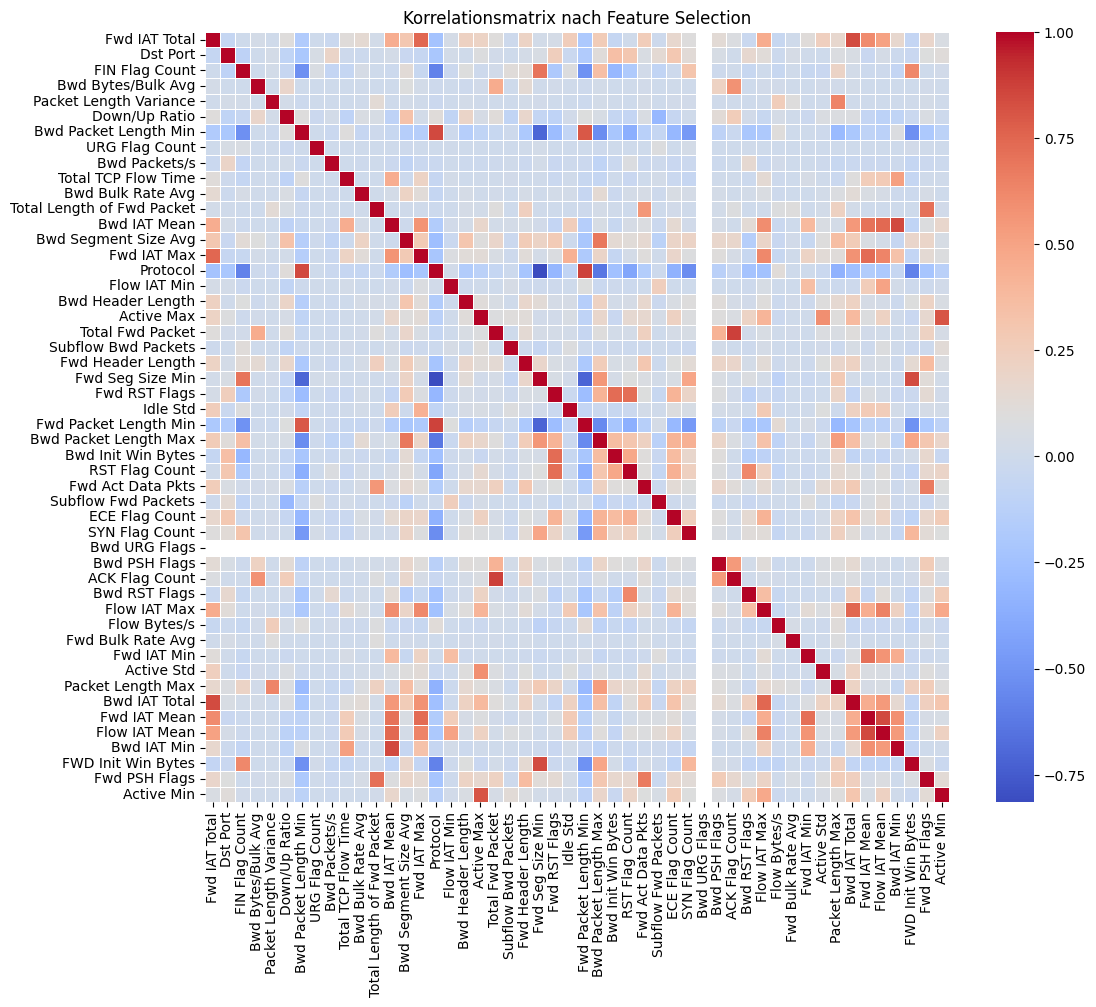

In [61]:
# Größe der Grafik 
plt.figure(figsize=(12, 10))

# Heatmap erstellen
sns.heatmap(correlation_matrix, 
            annot=False,        # Korrelationskoeffizienten anzeigen
            fmt=".2f",         # Format der Koeffizienten
            cmap="coolwarm",   # Farbschema der Heatmap
            linewidths=0.5)    # Linien zwischen den Zellen

# Titel hinzufügen (optional)
plt.title("Korrelationsmatrix nach Feature Selection")

# Grafik anzeigen
plt.show()